# Generate data for sparse coding with autoencoder

We select a few continuous measures, like heart rate, sBP, dBP, SpO2, and RR

Created: 2019-01-03

# Methods

In [1]:
%matplotlib inline
import os
import sys
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_orig()

/local/home/Asif/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/local/home/Asif/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_orig()

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 72

# green, red, blue, yellow, purple, blue, grey
flatui = ["#2DEC2A","#F6204F","#33CCFF","#FFCC33","#9b59b6","#25BCFE","#95a5a6"]
default_colors = ["#1E88E5", "#ff0d57", "#13B755", "#7C52FF", "#FFC000", "#00AEEF","#F9AE23"]

def fontsize(ax, fz = 14):
    """Set all fontsizes to fz"""
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fz)

def labels(ax, title=None, subtitle=None, xlabel=None, ylabel=None, xticklabels = None, legend_title = None, legend_labels=None, legend_loc = 'upper right', fz=14, grid=True):
    """Assign titles and labels.
    xticklabels and legend_labels should be lists, all others are strings."""
    if title is not None:
        if subtitle is None:
            plt.title(title)
        else:
            plt.suptitle(title, y=1, fontsize=fz+2)
            plt.title(subtitle)
    if xticklabels is not None:
        ax.set_xticklabels(xticklabels)
    if legend_title is not None and legend_labels is not None:
        handles, ax_legend_labs = ax.get_legend_handles_labels()
        ax.legend(handles, legend_labels, title=legend_title, loc=legend_loc)
    if xlabel is not None:
        plt.xlabel(xlabel);
    if ylabel is not None:
        plt.ylabel(ylabel);
    if grid:
        plt.grid(linestyle='dotted')
    fontsize(ax, fz)

def annotate(ax, x, y, text, offset=5):
    """Place text in different locations of the plot.
    x and y are lists of locations on the plot. text can be a list of numbers or strings."""
    for i in range(len(x)):
        ax.text(x[i], y[i]+offset, text[i], bbox={'facecolor':'white','pad':5}, horizontalalignment='center')

/local/home/Asif/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/local/home/Asif/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [3]:
from scipy import stats
EPS = 1e-12
def robust_transform(x, rescale=True):
    h = 1/(1 + np.exp( - (x-np.nanmedian(x)) / (1.35 * stats.iqr(x[np.isfinite(x)]) + EPS) ))
    if rescale:
        h = (h - np.nanmin(h)) / (np.nanmax(h) - np.nanmin(h))
    return h

# Load data

In [4]:
PATH = '/local/home/Asif/data/ards/'
files = [f for f in os.listdir(PATH) if f.endswith('.csv')]
print(len(files))

71972


In [5]:
parameters = ['FiO2', 'PaO2', 'PaCO2', 'pH', 'HR', 'RespRate', 'SpO2', 'NISysABP', 'NIDiaABP', 'NIMeanABP', 'Glucose', 'Temp', 'PEEP', 'BUN', 'Calcium', 'Creatinine', 'Bicarbonate', 'Hematocrit', 'Hemoglobin', 'Platelets', 'Potassium', 'Sodium', 'WBC', 'Albumin', 'Bilirubin', 'ALT', 'AST', 'ALP', 'Lactate', 'INR', 'TotalCO2', 'ISysABP', 'IDiaABP', 'IMeanABP', 'PTT', 'Bands', 'TVInsp', 'SaO2', 'PAPMean', 'PAPDia', 'PAPSys', 'PPlat', 'MAWP']

def load_file(f):
    df = pd.read_csv(PATH + f)
    pid = df.loc[df.Parameter == 'patientUnitStayID'].iloc[0].Value
    label_28day_mortality = float(df[df.Parameter == 'label_28day_mortality'].iloc[0].Value)
    timeOfID = float(df.loc[df.Parameter == 'timeOfID','Value'].iloc[0])
    df = df.loc[(df.Time>=timeOfID) & (df.Time<=(timeOfID+24*60)) & (df.Parameter.isin(parameters))].sort_values('Time').reset_index(drop=True).copy()
    df.loc[:,'Value'] = df.loc[:,'Value'].astype(float)
    df.loc[:,'Time'] = df.loc[:,'Time'] - timeOfID # time in minutes from ID
    df = df.assign(TimeStamp=[pd.Timestamp('2018-01-01') + pd.Timedelta(f'{t}m') for t in df.Time])
    return df, (pid, label_28day_mortality, timeOfID)

In [6]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel

def gp(t, x, m):
    kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-1, 1e1)) + WhiteKernel(noise_level=0.1)
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
    gp.fit(t[m, np.newaxis], x[m, np.newaxis])
    y = gp.predict(t[:, np.newaxis], return_std=False)
    return y

In [7]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
def svr(t,x,m):
    clf = SVR(kernel='rbf', C=1e3, gamma=0.1)
    clf.fit(t[m, np.newaxis], x[m])
    y = clf.predict(t[:, np.newaxis])
    return y

In [8]:
# clf = SVR(kernel='rbf', C=1e3, gamma=0.1)
# clf.fit(t[m, np.newaxis], xz[m])

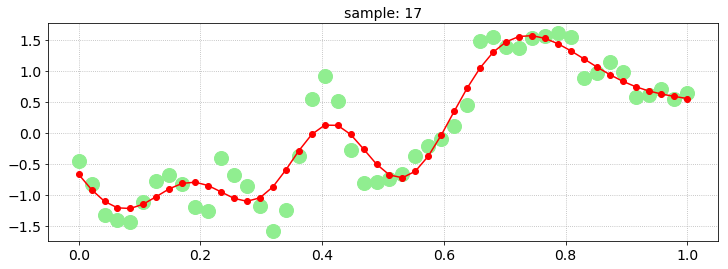

In [9]:
min_num_samples = 2
timesteps = 48

i = 17

df, meta = load_file(files[i])
dx = df[df.Parameter == 'HR']
if len(dx) > min_num_samples:
    x = dx.set_index('TimeStamp').resample('30min').mean()
    x = x.reindex(pd.date_range(start=pd.Timestamp('2018-01-01'), end=pd.Timestamp('2018-01-02'), freq='30min')).Value.round(2).values[0:timesteps]
    xz = (x - np.nanmean(x)) / np.nanstd(x) # zscore
    t = np.linspace(0,1,timesteps)
    m = np.isfinite(xz)
    y = gp(t,xz,m)
    # y = robust_transform(y)

plt.figure(figsize=(12,4))
ax = plt.subplot(1,1,1)
plt.plot(t,xz,'o',color='lightgreen',ms=14, label='measured')
plt.plot(t,y.ravel(),'o-',color='red')
labels(ax, title=f'sample: {i}')

In [14]:
def loaddata(f):
    df, meta = load_file(f)
    dx = df[df.Parameter == 'HR']
    if len(dx) > min_num_samples:
        x = dx.set_index('TimeStamp').resample('30min').mean()
        x = x.reindex(pd.date_range(start=pd.Timestamp('2018-01-01'), 
                                    end=pd.Timestamp('2018-01-02'), 
                                    freq='30min')).Value.round(2).values[0:timesteps]
        return x, meta[0]
    else:
        return None

In [15]:
def gpinterp(f):
    df, meta = load_file(f)
    dx = df[df.Parameter == 'HR']
    if len(dx) > min_num_samples:
        x = dx.set_index('TimeStamp').resample('30min').mean()
        x = x.reindex(pd.date_range(start=pd.Timestamp('2018-01-01'), 
                                    end=pd.Timestamp('2018-01-02'), 
                                    freq='30min')).Value.round(2).values[0:timesteps]
        xz = (x - np.nanmean(x)) / np.nanstd(x) # zscore
        t = np.linspace(0,1,timesteps)
        m = np.isfinite(xz)
        y = gp(t,xz,m)
        y = robust_transform(y)
        return y, meta[0]
    else:
        return None

In [16]:
# xs = {}
# n = len(files)
# for k,f in enumerate(files):
#     if k % 1000 == 0:
#         print(f'{k} of {n}')
#     out = gpinterp(f)
#     if out is not None:
#         xs[out[1]] = out[0]

In [17]:
# pids = list(xs.keys())
# plt.plot(t,xs[pids[0]])
# plt.plot(t,xs[pids[1]])
# plt.plot(t,xs[pids[2]])

In [18]:
import multiprocessing
from tqdm import tqdm

data = {}

pool = multiprocessing.Pool(processes=12)
with tqdm(total=len(files)) as progress_bar:
    for out in pool.imap_unordered(loaddata, files):
        if out is not None:
            data[out[1]] = out[0]
        progress_bar.update(1)

100%|██████████| 71972/71972 [04:37<00:00, 259.61it/s]


In [19]:
pool.close()

In [20]:
!free -hm

              total        used        free      shared  buff/cache   available
Mem:           251G        1.8G        241G         28M        8.6G        248G
Swap:           31G          0B         31G


In [22]:
pids = list(data.keys())

In [23]:
X = np.array(list(data.values()))

In [24]:
X.shape

(70715, 48)

In [40]:
# np.save('/local/home/Asif/data/tmp/ards_hr.npy',X.astype('f'))